The sinking of the Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the widely considered unsinkable RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew. While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others. In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).<br><br>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the Titanic datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
ss = pd.read_csv("gender_submission.csv")

In [3]:
train.head() #'PassengerId', 'Name', 'Ticket', 'Cabin'

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
train.shape

(891, 12)

In [6]:
test.shape

(418, 11)

In [7]:
train[['Sex', 'Survived']].groupby('Sex', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Text(0.5, 1.0, 'Survival Probability by Gender')

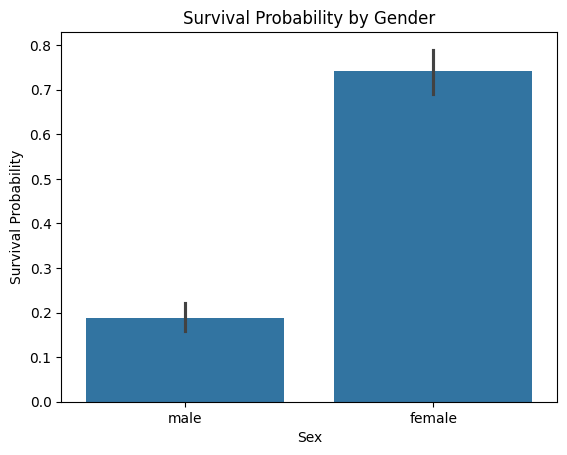

In [8]:
sns.barplot(x = 'Sex', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Gender')

Text(0.5, 1.0, 'Survival Probability by Passenger Class')

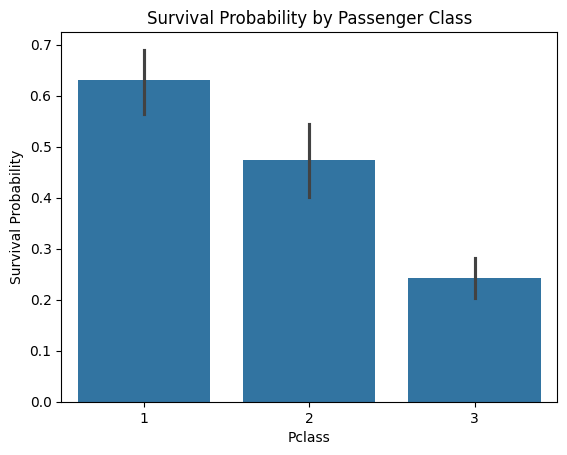

In [9]:
sns.barplot(x = 'Pclass', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Passenger Class')

In [10]:
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Text(0.5, 1.0, 'Survival Probability by Point of Embarkation')

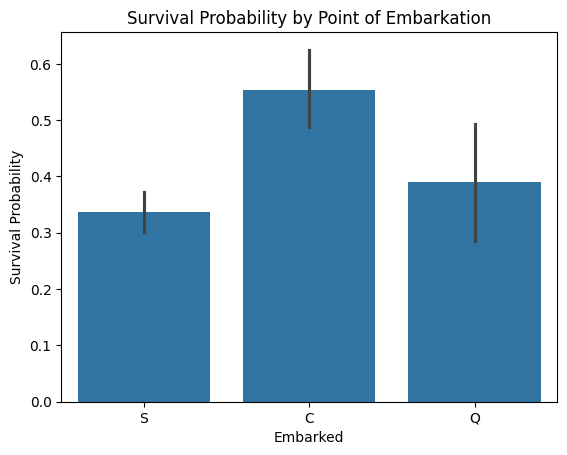

In [11]:
sns.barplot(x = 'Embarked', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Point of Embarkation')

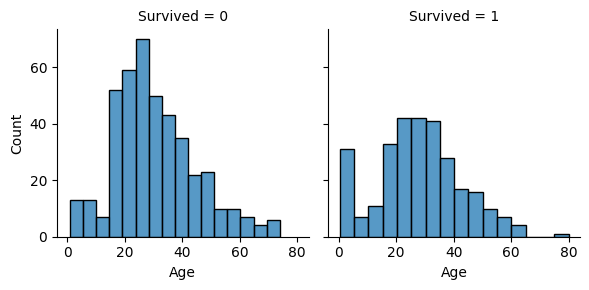

In [12]:
g = sns.FacetGrid(train, col = 'Survived')
g.map(sns.histplot, 'Age')

Text(0.5, 1.0, 'Passenger Age Distribution by Survival')

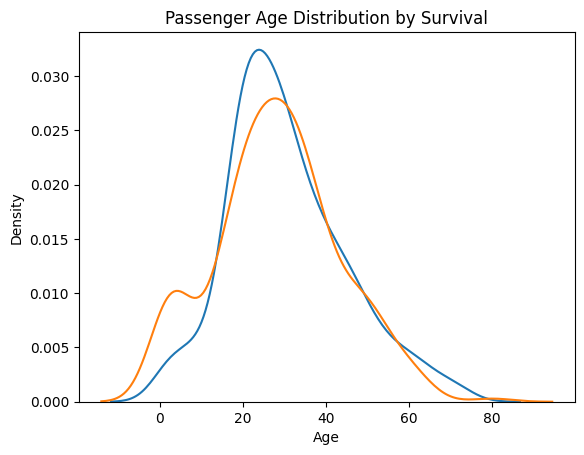

In [13]:
sns.kdeplot(train['Age'][train['Survived'] == 0], label = 'Did not survive')
sns.kdeplot(train['Age'][train['Survived'] == 1], label = 'Survived')
plt.xlabel('Age')
plt.title('Passenger Age Distribution by Survival')

In [14]:
full_data = pd.concat([train, test], axis=0, ignore_index=True)

In [15]:
full_data = full_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [16]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [17]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [18]:
full_data['Age'].fillna(full_data['Age'].median(), inplace=True)
full_data['Fare'].fillna(full_data['Fare'].median(), inplace=True)
full_data['Embarked'].fillna(full_data['Embarked'].mode()[0], inplace=True)

In [19]:
full_data['Sex'] = full_data['Sex'].map({'female': 0, 'male': 1})
full_data = pd.get_dummies(full_data, columns=['Pclass', 'Embarked'], drop_first=True)

In [20]:
# Split the data into features (X) and target (y)
X_train = full_data.loc[0:train.shape[0]-1].drop('Survived', axis=1)
y_train = full_data.loc[0:train.shape[0]-1]['Survived']
X_test = full_data.loc[train.shape[0]:].drop('Survived', axis=1)

In [21]:
X_train


,Sex,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,1,22.0,1,0,7.2500,False,True,False,True
1,0,38.0,1,0,71.2833,False,False,False,False
2,0,26.0,0,0,7.9250,False,True,False,True
3,0,35.0,1,0,53.1000,False,False,False,True
4,1,35.0,0,0,8.0500,False,True,False,True
...,...,...,...,...,...,...,...,...,...
886,1,27.0,0,0,13.0000,True,False,False,True
887,0,19.0,0,0,30.0000,False,False,False,True
888,0,28.0,1,2,23.4500,False,True,False,True
889,1,26.0,0,0,30.0000,False,False,False,False


In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=50)

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [25]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# Train the model
model.fit(X_train_scaled, y_train, epochs=70, batch_size=32, validation_data=(X_val_scaled, y_val))

Epoch 1/70


23/23 [==============================] - 2s 19ms/step - loss: 0.7159 - accuracy: 0.5562 - val_loss: 0.6706 - val_accuracy: 0.5754
Epoch 2/70
23/23 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5744 - val_loss: 0.6604 - val_accuracy: 0.5642
Epoch 3/70
23/23 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.6166 - val_loss: 0.6489 - val_accuracy: 0.5642
Epoch 4/70
23/23 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6250 - val_loss: 0.6275 - val_accuracy: 0.5642
Epoch 5/70
23/23 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6573 - val_loss: 0.6064 - val_accuracy: 0.5754
Epoch 6/70
23/23 [==============================] - 0s 3ms/step - loss: 0.6074 - accuracy: 0.6433 - val_loss: 0.5918 - val_accuracy: 0.5810
Epoch 7/70
23/23 [==============================] - 0s 3ms/step - loss: 0.6088 - accuracy: 0.6685 - val_loss: 0.5819 - val_accuracy: 0.7207
Epoch 8/70
23/23 

In [27]:

val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

6/6 [==============================] - 0s 4ms/step - loss: 0.4468 - accuracy: 0.8156
Validation Loss: 0.4468, Validation Accuracy: 0.8156


In [28]:
# Predict survival on the test set
predictions = model.predict(X_test_scaled)

14/14 [==============================] - 0s 912us/step


In [29]:
sample_input = X_train.iloc[0:1].copy()

sample_input['Pclass_2'] = 0  
sample_input['Pclass_3'] = 1  
sample_input['Sex'] = 1       
sample_input['Age'] = 25      
sample_input['SibSp'] = 1     
sample_input['Parch'] = 0     
sample_input['Fare'] = 30     
sample_input['Embarked_Q'] = 0  
sample_input['Embarked_S'] = 1 
sample_input_scaled = scaler.transform(sample_input)


sample_input_reshaped = sample_input_scaled.reshape(1, -1)

# Make a prediction
prediction = model.predict(sample_input_reshaped)
predicted_class = np.round(prediction).astype(int)

print("Sample Input:")
print(sample_input)
print("\nPredicted Class (Survived=1, Not Survived=0):", predicted_class[0, 0])


1/1 [==============================] - 0s 15ms/step
Sample Input:
     Sex  Age  SibSp  Parch  Fare  Pclass_2  Pclass_3  Embarked_Q  Embarked_S
567    1   25      1      0    30         0         1           0           1

Predicted Class (Survived=1, Not Survived=0): 0
